# Privacy Metrics DCR / NNDR
Exploring privacy metrics DCR / NNDR

## Load libraries and define settings

In [1]:
# general dependencies
import numpy as np
import pandas as pd
import sys
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# synthesis methods
from synthcity.plugins import Plugins
from synthcity.plugins.core.dataloader import GenericDataLoader

# repo code
from crnsynth.configs import config
from crnsynth.synth.custom_generators.privbayes_dk import PrivBayesDK
from crnsynth.synth.custom_generators.marginal_dk import MarginalDK
from crnsynth.synth.custom_generators.uniform_dk import UniformDK

from crnsynth.process import util
from crnsynth.evaluation import visual
from crnsynth.synth.synthpipe import BaseSynthPipe

# gives extra pandas methods for dataframes: bin_numeric_column, sample_from_binned_column
from synthesis.transformers import deidentification, generalization


/Users/dknoors/miniconda3/envs/crnsynth/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
<stdin>:1:10: fatal error: 'omp.h' file not found
#include <omp.h>
         ^~~~~~~
1 error generated.


[KeOps] Warning : omp.h header is not in the path, disabling OpenMP.
[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


[2024-01-25T15:27:03.938700+0100][11133][CRITICAL] module disabled: /Users/dknoors/miniconda3/envs/crnsynth/lib/python3.9/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2024-01-25T15:27:04.584448+0100][11133][CRITICAL] module disabled: /Users/dknoors/miniconda3/envs/crnsynth/lib/python3.9/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2024-01-25T15:27:04.585372+0100][11133][CRITICAL] module disabled: /Users/dknoors/miniconda3/envs/crnsynth/lib/python3.9/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2024-01-25T15:27:04.585912+0100][11133][CRITICAL] module disabled: /Users/dknoors/miniconda3/envs/crnsynth/lib/python3.9/site-packages/synthcity/plugins/generic/plugin_goggle.py


In [2]:
# autoreload changes from local files
%load_ext autoreload
%autoreload 2

# pandas show full output
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 200)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# constants
EPSILON = 1
DATASET_NAME = 'adult'
RANDOM_SEED = 42

## Load and process dataset

In [4]:
df_adult = pd.read_csv(config.PATH_DATA[DATASET_NAME])
df_adult.head()


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


## Generate
Here we show how step by step how to generate synthetic data.

We define our synthesis pipeline, this will help us perform all the steps the right order. You can inherit common functionality across synthesis pipelines, while also adding your own data-specific methods to it. 

This ensures that you can benefit from a defined structure without needing to re-implement the generic elements, while still having the flexbility to customize it to your needs.

In [5]:
class AdultSynthPipe(BaseSynthPipe):
    def __init__(
        self,
        generator,
        data_name="adult",
        target_column="income",
        test_size=0.2,
        output_train_format=False,
        generalize=True,
        data_loader_name="generic",
        random_state=None,
        warn=True,
        verbose=2,
    ) -> None:
        super().__init__(
            generator=generator,
            data_name=data_name,
            target_column=target_column,
            test_size=test_size,
            output_train_format=output_train_format,
            generalize=generalize,
            data_loader_name=data_loader_name,
            random_state=random_state,
            warn=warn,
            verbose=verbose,
        )

    def filter_raw_data(self, data_real):
        # reduce columns
        columns_subset = [
            "age",
            "workclass",
            "education",
            "marital-status",
            "occupation",
            "relationship",
            "race",
            "sex",
            "hours-per-week",
            "native-country",
            "income",
        ]
        data_real = data_real[columns_subset]
        return data_real


    def process_data(self, data_real):
        
        self._save_input_format(data_real)
        
        if self.generalize:
            loader_info = data_real.info()
            # cast to pd.DataFrame
            data_real = self._generalize_data(
                data_real.data
            )
            # cast to synthcity.DataLoader
            data_real = self.get_dataloader().from_info(data_real, loader_info)

        return data_real 
    
    def postprocess_synthetic_data(self, data_synth):

        loader_info = data_synth.info()

        # reverse generalization
        if self.generalize:
            data_synth = self._reverse_generalization(
                data_synth.data
            )

        # cast to synthcity.DataLoader
        data_synth = self.get_dataloader().from_info(data_synth, loader_info)
        return data_synth

    def _generalize_data(self, data_real):
        data_real = data_real.bin_numeric_column(
            column_name="age", n_bins=5, col_min=17, col_max=90, strategy="quantile"
        ).bin_numeric_column(
            column_name="hours-per-week",
            n_bins=5,
            col_min=1,
            col_max=99,
            strategy="quantile",
        )
        return data_real

    def _reverse_generalization(self, data_synth):
        data_synth = data_synth.sample_from_binned_column(
            column_name="age",
            numeric_type="int",
            mean=38,
            std=13,
            random_state=self.random_state,
        ).sample_from_binned_column(
            column_name="hours-per-week",
            numeric_type="int",
            mean=40,
            std=10,
            random_state=self.random_state,
        )
        return data_synth

SynthPipe allows you to perform a full synthesis pipeline step by step and allow you to inspect what happens. However, you can also use run() to perform all steps in order at once.

In [6]:
# choose generator privbayes
generator = Plugins().get('privbayes_dk', epsilon=EPSILON)
synth_pipe_pb = AdultSynthPipe(generator=generator, generalize=True, random_state=RANDOM_SEED)
df_real = synth_pipe_pb.filter_raw_data(df_adult)
loader_real = synth_pipe_pb.cast_to_dataloader(df_real)

df_pb = synth_pipe_pb.process_data(loader_real)
synth_pipe_pb.fit(df_pb.train())
df_synth_pb = synth_pipe_pb.generate()
df_synth_pb = synth_pipe_pb.postprocess_synthetic_data(df_synth_pb)

[2024-01-25T15:27:07.660171+0100][11133][CRITICAL] module disabled: /Users/dknoors/miniconda3/envs/crnsynth/lib/python3.9/site-packages/synthcity/plugins/generic/plugin_goggle.py
Bins whose width are too small (i.e., <= 1e-8). Consider decreasing the number of bins.


Using data loader for generic
Using data loader for generic
1/11 - Root of network: income

2/11 - Evaluating next attribute to add to network
Number of AttributeParentPair candidates: 10
Selected attribute: 'marital-status' - with parents: ('income',)

3/11 - Evaluating next attribute to add to network
Number of AttributeParentPair candidates: 11
Selected attribute: 'relationship' - with parents: ('marital-status', 'income')

4/11 - Evaluating next attribute to add to network
Number of AttributeParentPair candidates: 15
Selected attribute: 'sex' - with parents: ('marital-status', 'income', 'relationship')

5/11 - Evaluating next attribute to add to network
Number of AttributeParentPair candidates: 21
Selected attribute: 'age' - with parents: ('income', 'marital-status', 'sex')

6/11 - Evaluating next attribute to add to network
Number of AttributeParentPair candidates: 29
Selected attribute: 'occupation' - with parents: ('income', 'sex')

7/11 - Evaluating next attribute to add to net

invalid value encountered in divide


Number of records generated: 32561 / 32561
Synthetic Data Generated

Number of records generated: 32561 / 32561
Synthetic Data Generated

Using data loader for generic


In [7]:
synth_pipe_pb.generator.model.network_

[APPair(attribute='income', parents=None),
 APPair(attribute='marital-status', parents=('income',)),
 APPair(attribute='relationship', parents=('marital-status', 'income')),
 APPair(attribute='sex', parents=('marital-status', 'income', 'relationship')),
 APPair(attribute='age', parents=('income', 'marital-status', 'sex')),
 APPair(attribute='occupation', parents=('income', 'sex')),
 APPair(attribute='workclass', parents=('occupation',)),
 APPair(attribute='hours-per-week', parents=('occupation', 'sex')),
 APPair(attribute='education', parents=('income', 'relationship')),
 APPair(attribute='race', parents=('hours-per-week', 'relationship')),
 APPair(attribute='native-country', parents=('income', 'sex'))]

## Computing privacy metrics

In [9]:
from crnsynth.evaluation import visual
from crnsynth.evaluation.custom_privacy_metrics.dcr import compute_closest_distances
from crnsynth.evaluation.custom_privacy_metrics.nndr import compute_ratio_distances

Prior to computing the privacy metrics, you need to encode your data and ensure that all variables are numeric. You can still pass in the names of the categorical variables to ensure the distance metric is computed correctly for them. 

Fit native synthcity encoder (i.e. LabelEncoder) on real data and transform both real and synth with same encoder to ensure categories are consistent.

In [10]:
df_real_encode, encoders = loader_real.encode()
df_synth_pb_encode, _ = df_synth_pb.encode(encoders=encoders)

Compute distances closest record (DCR) and ratio between closest and fifth closest record (NNDR)

In [12]:
cat_features = ["workclass", "education", "marital-status", "occupation", "relationship", "race", "sex", "native-country", "income"]

dist_test, dist_synth = compute_closest_distances(
    df_train=df_real_encode.train().data, 
    df_test=df_real_encode.test().data,
    df_synth=df_synth_pb_encode.data,
    categorical_columns=cat_features,
    distance_metric='gower'
)

# ratio first to 5th neighbor
dist_ratio_test_5, dist_ratio_synth_5 = compute_ratio_distances(
    df_train=df_real_encode.train().data, 
    df_test=df_real_encode.test().data,
    df_synth=df_synth_pb_encode.data,
    categorical_columns=cat_features,
    n_neighbors=5,
    distance_metric='gower'
)

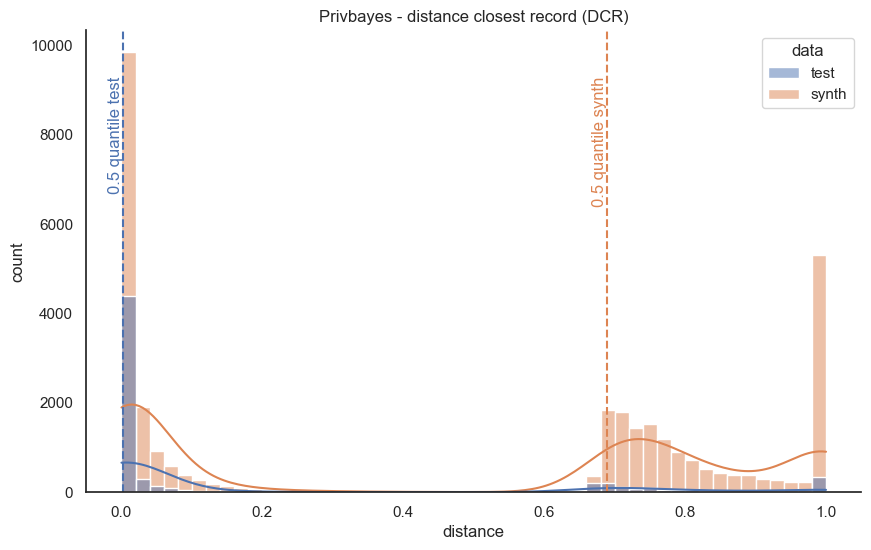

In [16]:
visual.plot_distances(dist_test, dist_synth, title='Privbayes - distance closest record (DCR)')

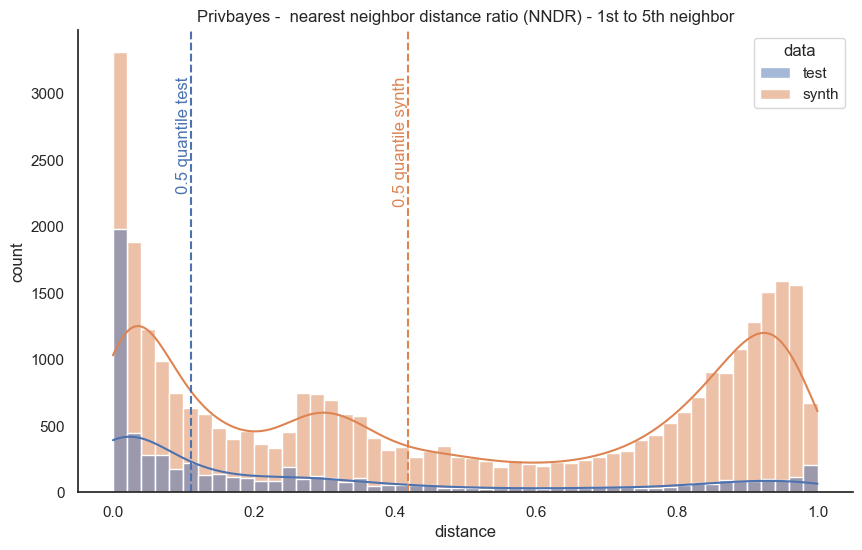

In [19]:
visual.plot_distances(dist_ratio_test_5, dist_ratio_synth_5, title='Privbayes -  nearest neighbor distance ratio (NNDR) - 1st to 5th neighbor')

Alternatively we could also look at the ratio between first and second nearest neighbor. 

In [18]:
# ratio first to second neighbor
dist_ratio_test_2, dist_ratio_synth_2 = compute_ratio_distances(
    df_train=df_real_encode.train().data, 
    df_test=df_real_encode.test().data,
    df_synth=df_synth_pb_encode.data,
    categorical_columns=cat_features,
    n_neighbors=2,
    distance_metric='gower'
)

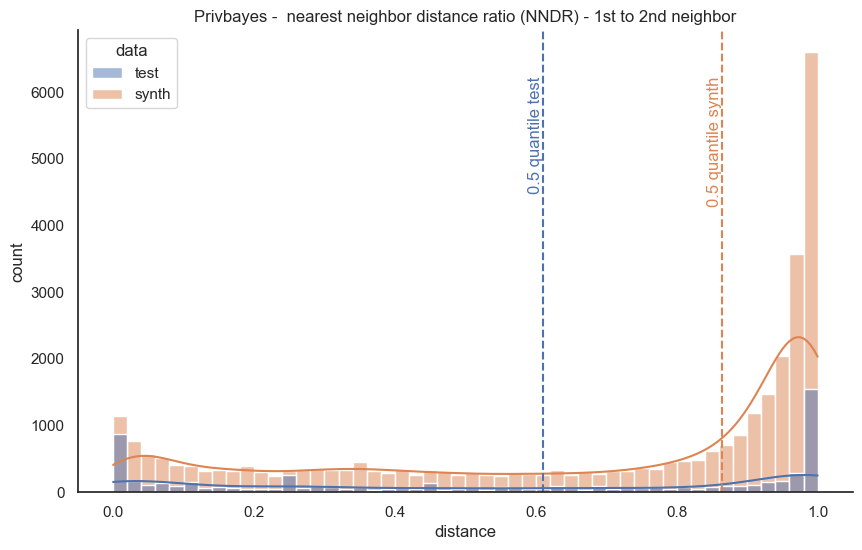

In [20]:
visual.plot_distances(dist_ratio_test_2, dist_ratio_synth_2, title='Privbayes -  nearest neighbor distance ratio (NNDR) - 1st to 2nd neighbor')